In [1]:
from module.prepare import *
from itertools import product
from sklearn.externals import joblib
from sklearn import metrics
from catboost import *
# import pygraphviz

D:\IDE_Project_Programming\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def scoreFunction(cv_results):
    scores = {
        'acc':[],
        'auc':[],
    }

    for result in cv_results:
        acc = metrics.accuracy_score(result[0],result[1])
        auc = metrics.roc_auc_score(result[0],result[1])
        scores['acc'].append(acc)
        scores['auc'].append(auc)
    
    return scores

#### LGB

In [4]:
def LGBTuning(Xtrain,Xtest,Ytrain,Ytest,tuning=True):
    
    clf = lgb.LGBMClassifier(objective='binary',
                             silent=False,
                             verbose=1,
                             random_state=seed,
                             n_jobs=4,
#                              class_weight
                            )
    
    gridParams = {
        # step 1
#     'learning_rate': [0.01,0.05,0.1],
#     'boosting_type':['gbdt','goss'],
#     'n_estimators': [50,200,500],
#     'num_iterations':[200,400,1000],
        # step 1 fixed
    'learning_rate': [0.1], ### 0.1
    'boosting_type':['gbdt'], ### goss>gbdt
    'n_estimators': [300],
    'num_iterations':[2000], ### 2000
        # step 2
    'num_leaves': [675], ### 675
#     'min_data_in_leaf':[18,20,22], ### 20 default
#     'max_bin':[127,255,511],
        # step 2 fixed
#     'num_leaves': [800],
    'max_bin':[256],
        # step 3
#     'max_depth':[7,8,9,10], ### missed
    'colsample_bytree' : [0.75], ### 0.75
#     'subsample_freq':[1,2,3], ### 1
#     'subsample' : [0.6,0.8,1], ### 1
#     'reg_alpha' : [0,0.1,0.5], ### 0
#     'reg_lambda' : [0,0.1,0.5], ### 0
    }

    if tuning:
        grid = GridSearchCV(clf, gridParams,
                        scoring='roc_auc',
                        verbose=3,
                        cv=5,
                        n_jobs=1)
        print('default params\n',clf.get_params())
        grid.fit(Xtrain,Ytrain)
        return grid
    else:
        arg_str = ''
        for k,v in gridParams.items():
            if type(v[0])==str:
                arg_str += k+'='+"'"+v[0]+"',"
            else:
                arg_str += k+'='+str(v[0])+","
        eval(
            'clf.'+clf.set_params.__name__+"("
                +arg_str.rstrip(',')+
                ")"
            )
#         clf.class_weight = {1:sum(Ytrain==1),0:sum(Ytrain==0)}
        print('default params\n',clf.get_params())
        clf.fit(Xtrain,Ytrain)
        Ypred = clf.predict_proba(Xtest)
        return [Ypred,Ytest,clf.score(Xtrain,Ytrain)]

In [ ]:
def LGBFit(X_train,X_test,Y_train,Y_test):
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

    params = {    
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'roc-auc',
#                 'nthread':6,
                'learning_rate':0.08,
                'num_leaves':300, 
                'max_depth': -1,   
                'subsample': 0.9, 
                'colsample_bytree': 0.9, 
                'feature_fraction': 1,
#                 'bagging_freq': 8,
# #                 'num_iterations':300,
#                 'min_data_in_leaf':2,
#                 'bagging_fraction': 0.8,
#                 'num_boost_round':3000,
            }

    cv_results = lgb.cv(params, lgb_train, nfold=5  
                        ,stratified=False, shuffle=True
                        ,seed=seed,
                        metrics=['auc','binary_logloss','mae']
                        ,verbose_eval=1)
    print('best n_estimators:', len(cv_results['auc-mean']))
    for k,v in cv_results.items():
        print('best cv score:', k, pd.Series(cv_results[k]).max())
    return [lgb,cv_results]

#### main

In [5]:
hyper_params = GetConfigure()
num_hyper_params = len(hyper_params)

cv = 5
generalize_ratio = 1.0/cv
test_ratio = 1.0/cv
mi_use = True

tuning_mode = True
if tuning_mode:
    cv = 1

cv_results = []

In [6]:
[data,T] = ReadData()

# for i in 
for batch in range(cv):
    INFO('cross validation batch %d'%batch)
    if mi_use==True:
        arr = ToMatrix(data,'sparse')
        [X_train,X_test,Y_train,Y_test] = MutualInformationFeatureSelection2(arr,data,generalize_ratio)
        [X_train,X_test,Y_train,Y_test] = \
            RandomForestDimensionalityReduction(X_train,X_test,Y_train,Y_test)
    else:
        [X,Y] = ToMatrix(data,'dense')
        [X_train,X_test,Y_train,Y_test] = SplitDataset(X,Y,generalize_ratio)
        [X_train,X_test,Y_train,Y_test] = \
            RandomForestDimensionalityReduction(X_train,X_test,Y_train,Y_test)
    if tuning_mode:
        break
        [Xtrain,Ytrain] = merge_train_test(X_train,X_test,Y_train,Y_test)
        grid = LGBTuning(Xtrain,[],Ytrain,[],True)
        cv_results.append(grid)
    else:
        scores = LGBTuning(X_train,X_test,Y_train,Y_test,False)
        cv_results.append(scores)


=============RETRIEVE TRIAN DATA=================
# DEBUG: # DEBUG: **************new dl 0***************
# DEBUG: READ SEQ FROM FILE
# DEBUG: READ CLUSTER FROM FILE
regex error 
regex error 
# DEBUG: READ PAIR FROM FILE
read line error 
# DEBUG: GENERATE NEGATIVE PAIR
# DEBUG: negative pair number 10412
INFO::count of negative pairs10412
# DEBUG: PAIR UNION
# DEBUG: EXTRACT FEATURES--PROTEIN
# DEBUG: EXTRACT FEATURES--RNA
# DEBUG: K-MER CALCULATION
# DEBUG: FEATURE UNION
# DEBUG: GARBAGE COLLECTION
MATRIX TRANSFORMATION
INFO::cross validation batch 0
data shape 20824 8984
dimension ratio 0.806768 dimension remained 7248
INFO::mutual information sum 35.750516 select 0.988227
INFO::MI params 0.000500
rf raw data fit score 1.000000
select top K features importances 0.9843642991841478
dimension remained 3500


#### test

In [ ]:
# DecisionTreePrefit(X_train,X_test,Y_train,Y_test)
[lgb,cv_results] = LGBFit(X_train,X_test,Y_train,Y_test)
WriteResult(DATASET,cv_results,conf,commons)

#### tuning

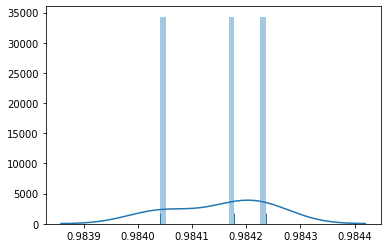

array([[0.9842361044112363,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 675}],
       [0.9841772232605589,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 675}],
       [0.9840418205184233,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 675}]],
      dtype=object)

In [92]:
sns.distplot(grid.cv_results_['mean_test_score'],rug=True,bins=20)
plt.show()
param_rank = np.array([grid.cv_results_['mean_test_score'],grid.cv_results_['params']]).T
a = sorted(param_rank,key=lambda x:x[0],reverse=True)
a = np.array(list(a))

a

In [12]:
from sklearn.naive_bayes import *
from sklearn.ensemble import *
nb = RandomForestClassifier()
nb.fit(X_train,Y_train)
print(nb.score(X_train,Y_train))
print(nb.score(X_test,Y_test))

0.9956780118854673
0.9308523409363746


In [8]:
Y_test

array([0, 1, 0, ..., 0, 1, 1])